# Hotel Recommendation - Collaborative Filtering & SVD

**Purpose:** Perform SVD to reduce the dimension of the 'Review Matrix' (i.e. hotel reviews and corresponding users) to produce hotel recommendations while reducing compute.

In [77]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns

## 1. Data Preparation
- Exploring customer information (i.e. rating, author, date(s) stayed, # of days stayed) and hotel information.
- The tables were merged to give a comprehensive map of the customer, hotel and rating given to it.
- Finally, 500 reviews were sampled to reduce compute cost with a corresponding 'review matrix' to conduct SVD.

In [78]:
offerings = pd.read_csv('./dataset/offerings.csv')
reviews = pd.read_csv('./dataset/reviews.csv')

In [79]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ratings            878561 non-null  object
 1   title              878561 non-null  object
 2   text               878561 non-null  object
 3   author             878561 non-null  object
 4   date_stayed        810967 non-null  object
 5   offering_id        878561 non-null  int64 
 6   num_helpful_votes  878561 non-null  int64 
 7   date               878561 non-null  object
 8   id                 878561 non-null  int64 
 9   via_mobile         878561 non-null  bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 61.2+ MB


In [80]:
offerings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hotel_class  3141 non-null   float64
 1   region_id    4333 non-null   int64  
 2   url          4333 non-null   object 
 3   phone        0 non-null      float64
 4   details      0 non-null      float64
 5   address      4333 non-null   object 
 6   type         4333 non-null   object 
 7   id           4333 non-null   int64  
 8   name         4333 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 304.8+ KB


In [98]:
offerings

,id,name
0,113317,Casablanca Hotel Times Square
1,76049,Four Seasons Hotel Los Angeles at Beverly Hills
2,99352,Hilton Garden Inn Times Square
3,93589,The Michelangelo Hotel
4,217616,The Muse Hotel New York
...,...,...
4328,84090,Park Hyatt Washington
4329,84065,Four Seasons Washington D.C.
4330,84093,"Palomar Washington DC, a Kimpton Hotel"
4331,235513,Sofitel Washington DC


In [81]:
reviews = reviews[["ratings", "author", "offering_id"]]
offerings = offerings[["id", "name"]]
reviews

,ratings,author,offering_id
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","{'username': 'Papa_Panda', 'num_cities': 22, '...",93338
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",93338
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...","{'username': 'vuguru', 'num_cities': 12, 'num_...",1762573
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","{'username': 'Hotel-Designer', 'num_cities': 5...",1762573
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...","{'username': 'JamesE339', 'num_cities': 34, 'n...",1762573
...,...,...,...
878556,{'overall': 4.0},"{'username': '', 'id': '', 'location': ''}",84093
878557,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...","{'username': 'dan016', 'num_reviews': 2, 'num_...",84093
878558,"{'cleanliness': 5.0, 'overall': 5.0, 'rooms': ...","{'username': '', 'id': '', 'location': ''}",84093
878559,"{'cleanliness': 5.0, 'overall': 5.0, 'rooms': ...","{'username': '', 'id': '', 'location': ''}",84093


In [82]:
reviews["ratings"] = reviews["ratings"].apply(ast.literal_eval)
reviews["author"] = reviews["author"].apply(ast.literal_eval)

In [83]:
reviews["ratings"] = reviews["ratings"].transform(lambda x: x["overall"])
reviews["author"] = reviews["author"].transform(lambda x: x["username"])

In [84]:
# Final dataset
reviews.head()

,ratings,author,offering_id
0,5.0,Papa_Panda,93338
1,5.0,Maureen V,93338
2,4.0,vuguru,1762573
3,4.0,Hotel-Designer,1762573
4,4.0,JamesE339,1762573


In [85]:
N = 500
hotel_reviews = pd.merge(reviews, offerings, left_on="offering_id", right_on="id").drop(columns=["offering_id", "id"])
hotel_reviews = hotel_reviews.sample(N)

In [86]:
review_matrix = pd.pivot_table(hotel_reviews, index="author", columns="name", values="ratings")

In [99]:
# Review Matrix (columns - hotels, rows - customers) & fill NaN with 1 (neutral rating)
review_matrix[review_matrix.isna()] = 1
review_matrix.head()

name,70 park avenue hotel - a Kimpton Hotel,Adolphus Hotel,Affinia 50,Affinia Dumont,Affinia Manhattan,Affinia Shelburne,Alexis Hotel - a Kimpton Hotel,"Algonquin Hotel Times Square, Autograph Collection",Allerton Hotel,Aloft Charlotte Uptown at the EpiCentre,...,Westin Philadelphia,Westin Phoenix Downtown,"White Swan Inn, a Joie de Vivre Hotel",Wilshire Crest Hotel,Wingate By Wyndham Charlotte Airport I-85/I-485,Woogo Apartments - Times Square,YOTEL New York at Times Square West,aloft Philadelphia Airport,enVision Hotel Boston,the Lexington
author,,,,,,,,,,,,,,,,,,,,,
,3.0,1.0,1.0,5.0,1.0,4.5,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
123Believe,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
255100Max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2forever1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A C,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 2. Singular Value Decomposition (SVD) on Review Matrix

- Perform SVD using iterative power methods to obtain a 'well-ordered' singular values and corresponding eigenvectors. 
    1. Random vector is initialized & normalized to begin power method.
    2. Either A^T A or A A^T is on power method to make it converge to a eigenvector corresponding to a dominant eigenvalue.
    3. The eigenvalue then becomes the singular value with the the eigenvector being p or q.
    4. The process continues while performing 'matrix deflation', so we can compute the next singular value & eigenvectors.

- Comparison is made between the Numpy SVD with our own & Visualized the errors.

- We use the eigenvectors (q) -- the weight vectors -- that capture the n-th most variance to create a recommendation system.
  - Compute time and dimension is significantly reduced.
  - Cosine similarity score allows correct calculation while maximizing variance of data with just 5 vectors instead of 401.

- SVD and the Weight vectors are visualized with Matplotlib and Seaborn.

In [88]:
# Random iniialized vector 
def initialize_vector(A):
    vec = np.random.rand(min(A.shape))
    return vec / np.linalg.norm(vec)

In [89]:
# Power Method
def power_iteration_svd(x, A, tol):
    
    if A.shape[0] > A.shape[1]:
        sqm = np.dot(A.T, A)
    else:
        sqm = np.dot(A, A.T)
    
    prev = x
    k = 1
    
    while True:
        print(f"{k}-th iteration.")
        
        x_i = np.dot(sqm, prev)
        x_norm = np.linalg.norm(x_i)
        x_i = x_i / x_norm

        if np.linalg.norm(prev - x_i) < tol:
            return x_i
        
        prev = x_i     
        k+=1 

In [90]:
# Obtain SVD via iterated power method
def get_svd(n):
    A = review_matrix.copy()
    svd_list = []
    SVD_SIZE = min(n, np.linalg.matrix_rank(A))
    init = initialize_vector(A)

    for i in range(SVD_SIZE):
        
        for p,s,q in svd_list[:i]:
            A -= s * np.outer(p,q)
            
        q = power_iteration_svd(init, A, 1e-10)
    
        p = np.dot(A, q)
        sigma = np.linalg.norm(p)
        p = p / sigma
        
        svd_list.append((p, sigma, q))
        
    return svd_list

In [ ]:
# Obtain SVD with 5 singular values

N = 5
p, s, qt = [np.array(x) for x in zip(*get_svd(N))] 
print(p.T.shape, s.shape, qt.shape)

# Ensure correct dimensions
assert p.T.shape == (review_matrix.shape[0], N) and s.shape == (N,) and qt.shape == (N, review_matrix.shape[1])

# Ensure orthogonality
assert np.dot(qt[0], qt[1]) < 0.000001
assert np.dot(p[0], p[1]) < 0.000001


1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
6-th iteration.
7-th iteration.
8-th iteration.
9-th iteration.
10-th iteration.
11-th iteration.
12-th iteration.
13-th iteration.
14-th iteration.
15-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
6-th iteration.
7-th iteration.
8-th iteration.
9-th iteration.
(454, 5) (5,) (5, 401)


In [92]:
# Singular Value Decomposition numerically via Numpy
U, S, V = np.linalg.svd(review_matrix)

1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
6-th iteration.
7-th iteration.
8-th iteration.
9-th iteration.
10-th iteration.
11-th iteration.
12-th iteration.
13-th iteration.
14-th iteration.
15-th iteration.
16-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
6-th iteration.
7-th iteration.
8-th iteration.
9-th iteration.
10-th iteration.
11-th iteration.
12-th iteration.
13-th iteration.
14-th iteration.
15-th iteration.
16-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
1-th iteration.
2-th iteration.
3-th iteration.
4-th iteration.
5-th iteration.
6-th itera

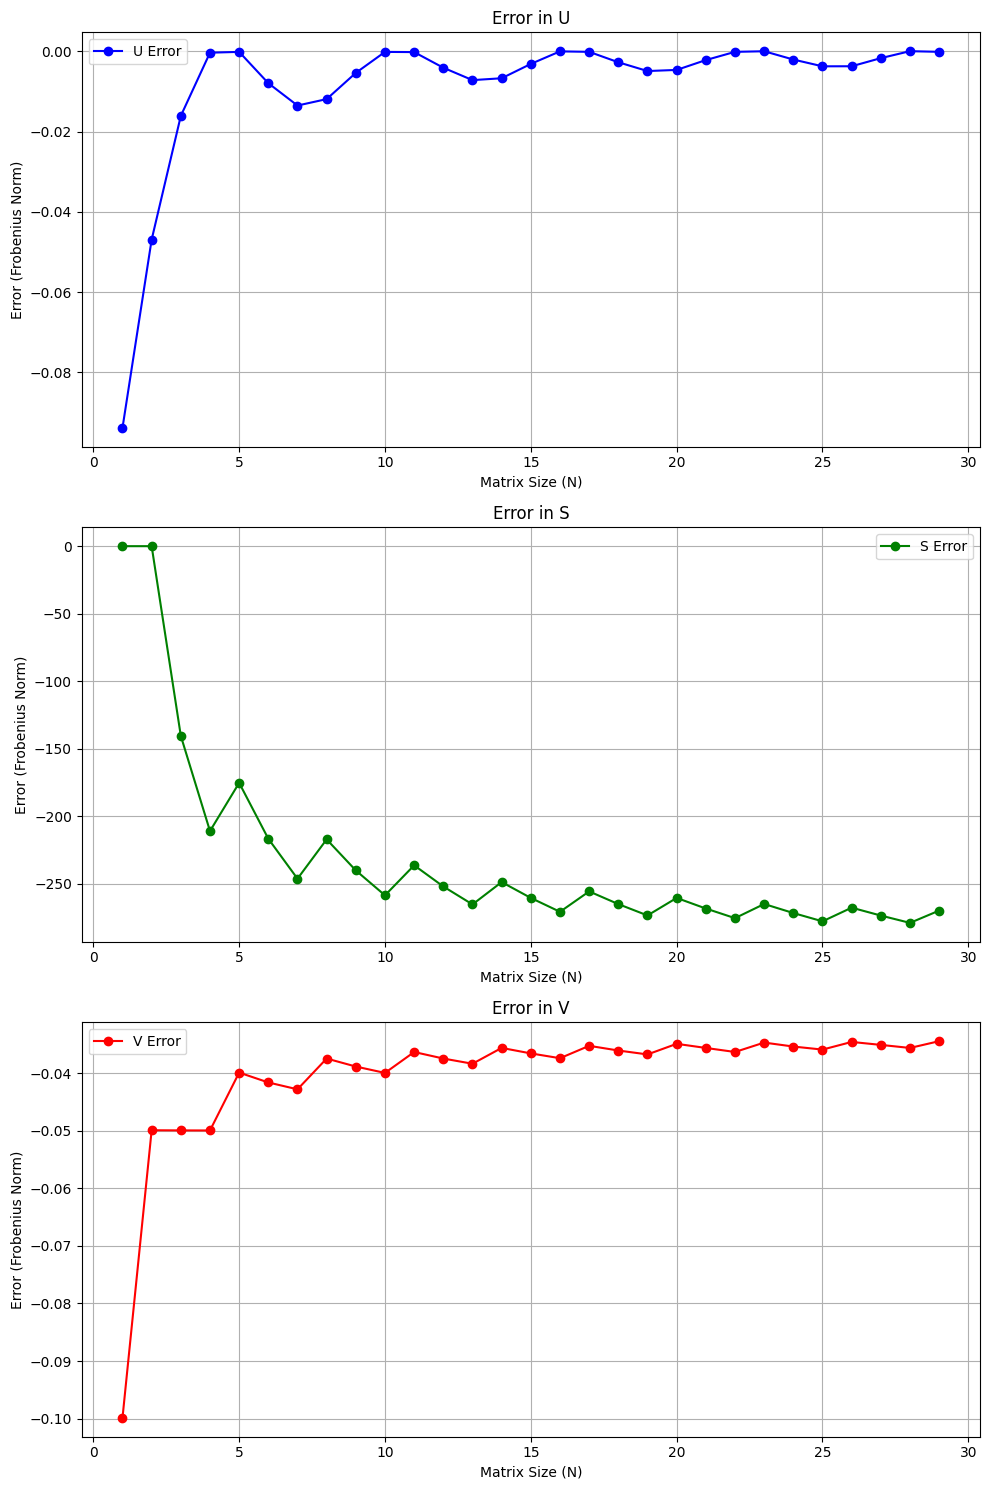

In [ ]:
# Ensure that the error doesn't inflate between Numpy SVD and our custom SVD
import numpy as np
import matplotlib.pyplot as plt

def error_analysis():

    u_errors, s_errors, v_errors = [], [], []

    for n in range(1,30):
        
        # Compute SVD using the custom implementation
        p, s, qt = [np.array(x) for x in zip(*get_svd(n))]
        
        # Calculate errors
        u_error = np.mean(U[:, :n] - p.T)  
        s_error = np.mean(S[:n] - s)
        v_error = np.mean(V[:n, :] - qt)
        
        # Store errors
        u_errors.append(u_error)
        s_errors.append(s_error)
        v_errors.append(v_error)

    # Plot errors
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))
    
    x_values = range(1, 30)
    ax[0].plot(x_values, u_errors, label="U Error", marker='o', color='blue')
    ax[0].set_title("Error in U")
    ax[0].set_xlabel("Matrix Size (N)")
    ax[0].set_ylabel("Error (Frobenius Norm)")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(x_values, s_errors, label="S Error", marker='o', color='green')
    ax[1].set_title("Error in S")
    ax[1].set_xlabel("Matrix Size (N)")
    ax[1].set_ylabel("Error (Frobenius Norm)")
    ax[1].grid(True)
    ax[1].legend()

    ax[2].plot(x_values, v_errors, label="V Error", marker='o', color='red')
    ax[2].set_title("Error in V")
    ax[2].set_xlabel("Matrix Size (N)")
    ax[2].set_ylabel("Error (Frobenius Norm)")
    ax[2].grid(True)
    ax[2].legend()

    plt.tight_layout()
    plt.show()

error_analysis()

We can claim that our custom results are reasonably close with the numerical result. The errors of matrix P and Q converge nearly to 0, while the Sigma increases in error but begins to converge to a reasonably low value.

In [94]:
# We gather the weight vectors (q) in a dataframe 

weight_vectors_df = pd.DataFrame(qt.T)
hotel_names = pd.DataFrame(review_matrix.unstack().reset_index()["name"].unique())
    
weight_vectors_df = pd.merge(weight_vectors_df, hotel_names, left_index=True, right_index=True)

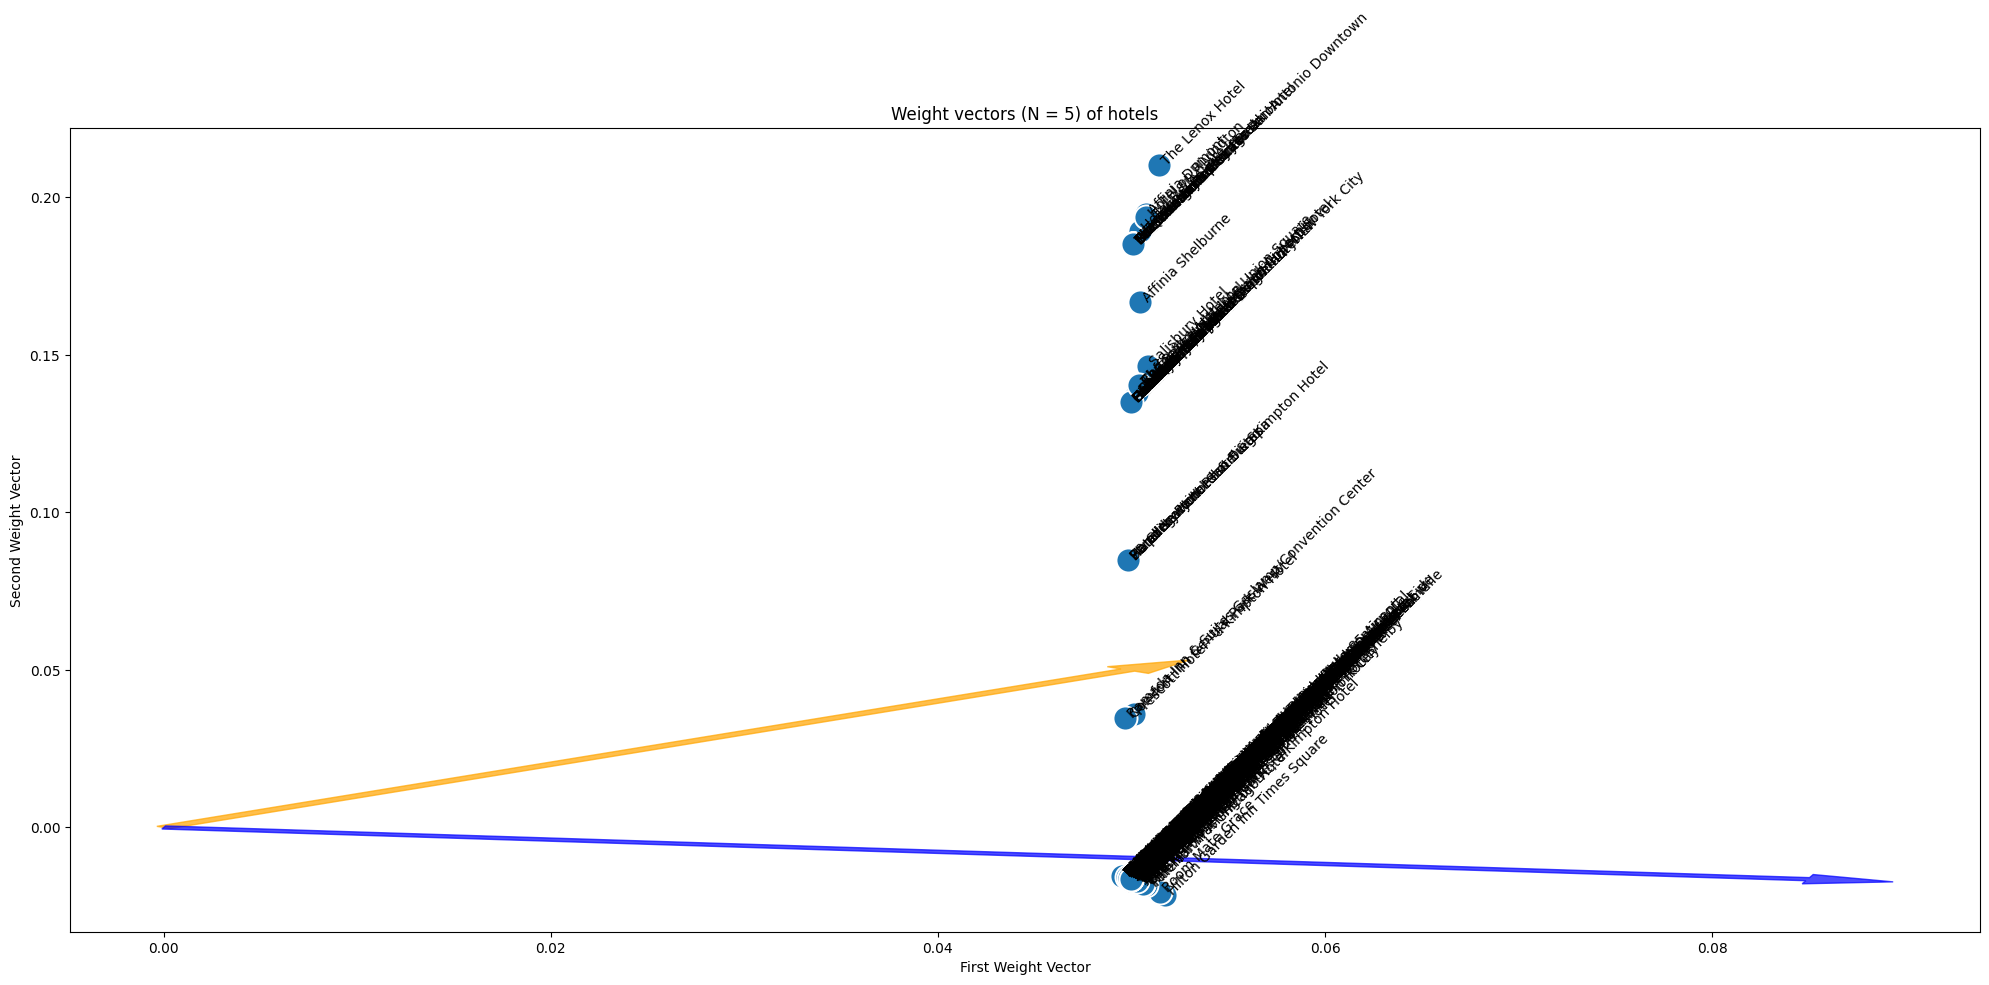

None


In [100]:
# Visualize the weight vectors
def plot_svd():
    plt.figure(figsize=(20,10))
    
    sns.scatterplot(x=weight_vectors_df.iloc[:, 0], y=weight_vectors_df.iloc[:, 1], s=300, markers='-')
    
    for i in range(weight_vectors_df.shape[0]):
        plt.annotate(weight_vectors_df["0_y"].iloc[i], xy=(weight_vectors_df["0_x"].iloc[i], weight_vectors_df[1].iloc[i]), size=10, rotation=45)
        
    plt.arrow(0, 0, weight_vectors_df["0_x"].iloc[0], weight_vectors_df["0_x"].iloc[1], color='orange', alpha=0.7)
    plt.arrow(0, 0, weight_vectors_df[1].iloc[0], weight_vectors_df[1].iloc[1], color='blue', alpha=0.7)
    
    plt.xlabel("First Weight Vector")
    plt.ylabel("Second Weight Vector")
    plt.title("Weight vectors (N = 5) of hotels")

    plt.tight_layout()
    plt.show()

    return
    
print(plot_svd())

Given this, the first 2 weight vectors capture the variance of the data points reasonably -- the vertical spead & horizontal pattern of each cluster. We need to ensure that the first 2 weight vectors are orthogonal. While it doesn't seem perfectly 90 degrees, remember we have 400+ dimensions. We can assume that (or check using dot product) that the 2 weight vectors are orthgonal.

## Recommendation Function

The function operates as follows:
1. Takes a user id (that already has been to a hotel / has a rating) as an input.
2. Find the rating vector from the 'q' vectors -- the rating vectors with reduced dimension.
3. Calculate Cosine Similarity score for each weight vectors.
4. Excluding the hotel the user previously went to, find the top 5 most similar hotels.

In [96]:
def recommend_hotels(user_id, k):
    rating = review_matrix.iloc[user_id].values
    rated_hotel_idx = rating.argmax()
    best_hotel = hotel_names.iloc[rated_hotel_idx].values
    rated_hotel = qt[:,rated_hotel_idx]
    
    cosine_similarity = np.dot(qt.T, rated_hotel) / ((np.linalg.norm(qt.T, axis=1) * np.linalg.norm(rated_hotel)))
    
    closest_idx = pd.DataFrame(cosine_similarity).sort_values(by=0, ascending=False).iloc[1:k+1].index
    return best_hotel, weight_vectors_df.iloc[closest_idx]["0_y"].values

In [ ]:
# Results
K= 50
for i in range(1,K):
    best_hotel, recommended = recommend_hotels(i, 5)
    print(f"User {i} - Best Hotel: {best_hotel}, Recommended Hotels: {recommended}.")
    print(" ")

User 1 - Best Hotel: ['The Lenox Hotel'], Recommended Hotels: ['Affinia Dumont' 'Hotel on Rivington' 'Hotel Belleclaire' 'the Lexington'
 'Silver Cloud Inn - Lake Union'].
 
User 2 - Best Hotel: ['InterContinental New York Barclay'], Recommended Hotels: ['The Westin Seattle' 'Holiday Inn SoHo New York'
 'BEST WESTERN PLUS Island Palms Hotel & Marina' 'Hilton Baltimore'
 'Holiday Inn Express New York City Times Square'].
 
User 3 - Best Hotel: ['JW Marriott Washington DC'], Recommended Hotels: ['The Hampton Inn Times Square North' 'Magic Castle Hotel'
 'Doubletree by Hilton Detroit Downtown - Fort Shelby' 'W New York'
 'Casablanca Hotel Times Square'].
 
User 4 - Best Hotel: ['W New York'], Recommended Hotels: ['The Westin Los Angeles Airport' 'JW Marriott Washington DC'
 'Magic Castle Hotel' 'Casablanca Hotel Times Square'
 'Doubletree by Hilton Detroit Downtown - Fort Shelby'].
 
User 5 - Best Hotel: ['Indianapolis Days Inn & Suites Castleton'], Recommended Hotels: ['Homewood Suites b

To verify this works, you can look at users with the same 'best hotels' and different 'best hotels' and see how the recommendations compare!